# **Part 1**

**Load the image**

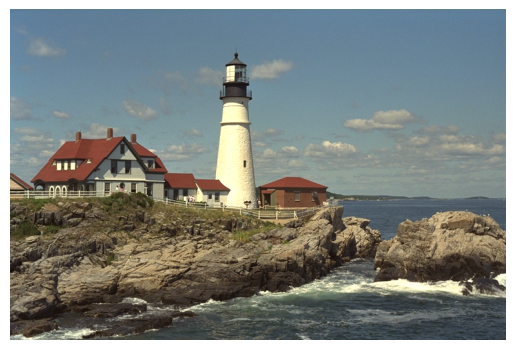

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/drive/MyDrive/AIP Assignment 3/lighthouse2.bmp'

# Read the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

**Convert image to grayscale**

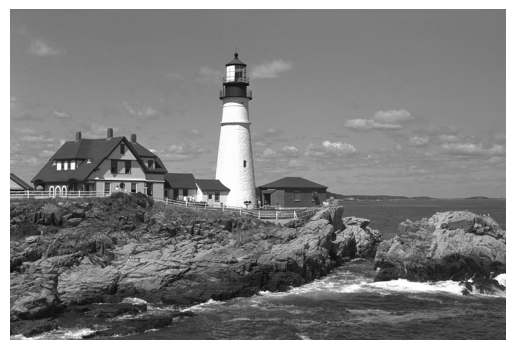

In [ ]:
# Import the rgb2gray function
from skimage.color import rgb2gray

# Convert the image to grayscale
gray_img = rgb2gray(img)

# Display the grayscale image
plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.show()

**Add noise**

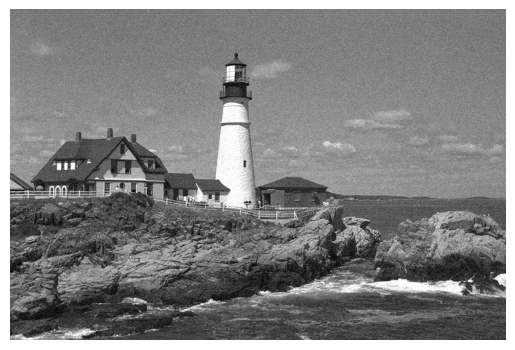

In [ ]:
import numpy as np

# Ensure the grayscale image is in the 0-255 range
gray_img_255 = gray_img * 255

# Define the noise variance and standard deviation
variance = 100
sigma = np.sqrt(variance)

# Generate the same size Gaussian noise
noise = np.random.normal(0, sigma, gray_img_255.shape)

# Add the noise to the grayscale image
noisy_img = gray_img_255 + noise

# Clip the values to be in the 0-255 range and convert to uint8 for displaying
noisy_img_clipped = np.clip(noisy_img, 0, 255).astype(np.uint8)

# Display the noisy grayscale image
plt.imshow(noisy_img_clipped, cmap='gray')
plt.axis('off')
plt.show()

**Low pass gaussian filter**

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np

# Function to calculate MSE
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# Lists of filter lengths and standard deviations to iterate over
filter_lengths = [3, 7, 11]
std_devs = [0.1, 1, 2, 4, 8]

# Initialize variables to track the best MSE and corresponding filter configuration
best_mse = np.inf
best_config = None
best_denoised_img = None

# Display the original noisy image
plt.figure(figsize=(8, 8))
plt.imshow(noisy_img_clipped, cmap='gray')
plt.title("Original Noisy Image")
plt.axis('off')
plt.show()

# Iterate over all combinations of filter lengths and standard deviations
for length in filter_lengths:
    for std_dev in std_devs:
        # Apply Gaussian filter
        denoised_img = gaussian_filter(noisy_img_clipped, sigma=std_dev, truncate=length/2.0/std_dev)

        # Calculate MSE
        current_mse = mse(original_img_255.astype("float"), denoised_img.astype("float"))

        # Update the best MSE and configuration if the current MSE is lower
        if current_mse < best_mse:
            best_mse = current_mse
            best_config = (length, std_dev)
            best_denoised_img = denoised_img

        # Plot each denoised image with its MSE
        plt.figure(figsize=(6, 6))
        plt.imshow(denoised_img, cmap='gray')
        plt.title(f"Length = {length}, Std Dev = {std_dev}, MSE = {current_mse:.2f}")
        plt.axis('off')
        plt.show()

# After all iterations, highlight the best configuration
print(f"Best Filter Configuration: Length = {best_config[0]}, Std Dev = {best_config[1]}, MSE = {best_mse}")
plt.figure(figsize=(8, 8))
plt.imshow(best_denoised_img, cmap='gray')
plt.title(f"Best Denoised Image\nLength = {best_config[0]}, Std Dev = {best_config[1]}, MSE = {best_mse:.2f}")
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Part II**

**Transforming the original and the noisy images into the high-pass domain**

This is achieved by subtracting a low-pass (smoothed) version of the image from the original image, which highlights the edges and details (high-frequency components) by removing the smoother, low-frequency components.

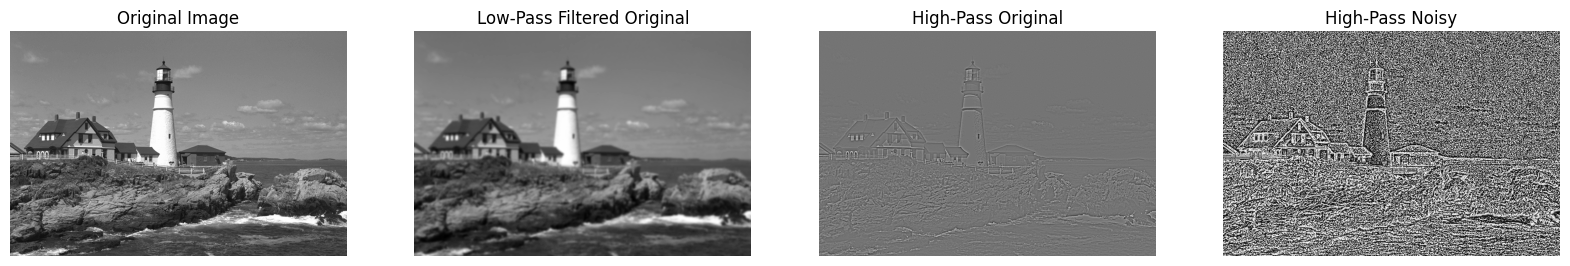

In [ ]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Apply Gaussian filter for low-pass filtering
sigma_low_pass = 2

# Low-pass versions of the original and noisy images
low_pass_original = gaussian_filter(gray_img_255, sigma=sigma_low_pass)
low_pass_noisy = gaussian_filter(noisy_img_clipped, sigma=sigma_low_pass)

# Step 2: Subtract the low-pass filtered image from the original to get the high-pass version
high_pass_original = gray_img_255 - low_pass_original
high_pass_noisy = noisy_img_clipped - low_pass_noisy

# Plotting to visualize the transformation
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(gray_img_255, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(low_pass_original, cmap='gray')
ax[1].set_title('Low-Pass Filtered Original')
ax[1].axis('off')

ax[2].imshow(high_pass_original, cmap='gray')
ax[2].set_title('High-Pass Original')
ax[2].axis('off')

ax[3].imshow(high_pass_noisy, cmap='gray')
ax[3].set_title('High-Pass Noisy')
ax[3].axis('off')

plt.show()

**Patch Extraction and Variance Calculation**

In [ ]:
import numpy as np
from skimage.util import view_as_windows

# Define a function to extract patches with a given size and overlap
def extract_patches(img, patch_size, overlap):
    # Calculate the step size from the overlap
    step = patch_size - overlap
    # Use view_as_windows to extract patches
    patches = view_as_windows(img, window_shape=patch_size, step=step)
    return patches.reshape(-1, patch_size, patch_size)

# Patch size and overlap
patch_size = 32
overlap = 16

# Extract patches from the high-pass original image
patches_original = extract_patches(high_pass_original, patch_size, overlap)

# Calculate the variance of each patch from the high-pass original image
variances_original = np.var(patches_original, axis=(1, 2))

# Print some of the variances to check
for i in range(5):
    print(f"Variance of patch {i}: {variances_original[i]}")

Variance of patch 0: 3.546379617544334
Variance of patch 1: 3.255354327550534
Variance of patch 2: 3.1358560965985145
Variance of patch 3: 3.1597179879684116
Variance of patch 4: 3.2064334616025993


**Implementation of the Noise Variance Calculation and Adaptive MMSE Filter**

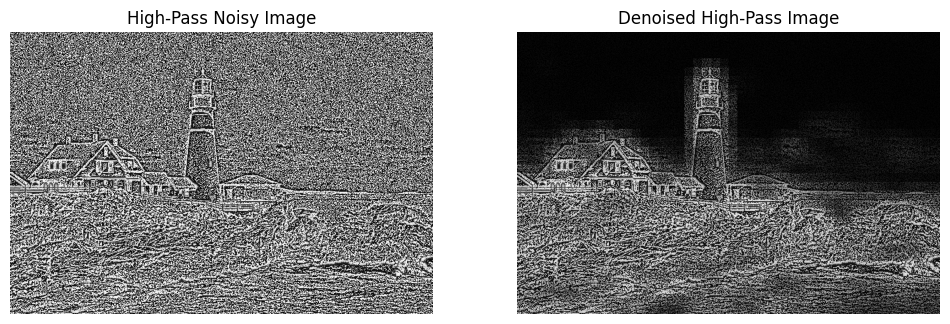

In [ ]:
sigma_Z_squared = 100

# Calculate the high-pass noise variance based on the given sigma^2_Z
# Since we are in the high-pass domain, the noise variance remains the same
high_pass_noise_variance = sigma_Z_squared

# Define a function for the MMSE filter
def apply_mmse_filter(noisy_patch, signal_variance, noise_variance):
    # Compute the Wiener filter gain
    wiener_gain = signal_variance / (signal_variance + noise_variance)
    # Apply the Wiener gain to the noisy patch
    denoised_patch = wiener_gain * noisy_patch
    return denoised_patch

# Apply the MMSE filter to all patches and store the denoised patches
denoised_patches = []

# Extract patches from the high-pass noisy image
patches_noisy = extract_patches(high_pass_noisy, patch_size, overlap)

for i, noisy_patch in enumerate(patches_noisy):
    # Apply the adaptive MMSE filter to each patch
    denoised_patch = apply_mmse_filter(noisy_patch, variances_original[i], high_pass_noise_variance)
    denoised_patches.append(denoised_patch)

# Convert the list of denoised patches to a NumPy array
denoised_patches = np.array(denoised_patches)

# Reconstruct the denoised image from the denoised patches
# This function needs to handle the averaging of overlapping patches
def reconstruct_image_from_patches(patches, img_shape, patch_size, overlap):
    # Initialize the image with zeros and a counter matrix for averaging
    reconstructed_img = np.zeros(img_shape)
    count_matrix = np.zeros(img_shape)

    # Calculate the step size from the overlap
    step = patch_size - overlap
    patch_idx = 0
    for i in range(0, img_shape[0] - patch_size + 1, step):
        for j in range(0, img_shape[1] - patch_size + 1, step):
            # Add the denoised patch to the reconstructed image
            reconstructed_img[i:i + patch_size, j:j + patch_size] += patches[patch_idx]
            # Increment the counter matrix to keep track of how many patches contribute to each pixel
            count_matrix[i:i + patch_size, j:j + patch_size] += 1
            patch_idx += 1

    # Average the overlapping patches by dividing the reconstructed image by the count matrix
    reconstructed_img /= count_matrix
    return reconstructed_img

# The shape of the high-pass noisy image
img_shape = high_pass_noisy.shape

# Reconstruct the denoised high-pass image
denoised_high_pass_img = reconstruct_image_from_patches(denoised_patches, img_shape, patch_size, overlap)

# Plot the original noisy and the denoised high-pass images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(high_pass_noisy, cmap='gray')
axes[0].set_title('High-Pass Noisy Image')
axes[0].axis('off')

axes[1].imshow(denoised_high_pass_img, cmap='gray')
axes[1].set_title('Denoised High-Pass Image')
axes[1].axis('off')

plt.show()

**Observation:**


*   Denoised High-Pass Image shows a noticeable reduction in noise compared to the "High-Pass Noisy Image
*    Important details, like edges and textures, still be visible in the denoised image, although they might appear smoother than in the noisy image due to the denoising process.



**Combine the denoised high-pass image with the low-pass filtered image to reconstruct the full denoised image in the pixel domain**

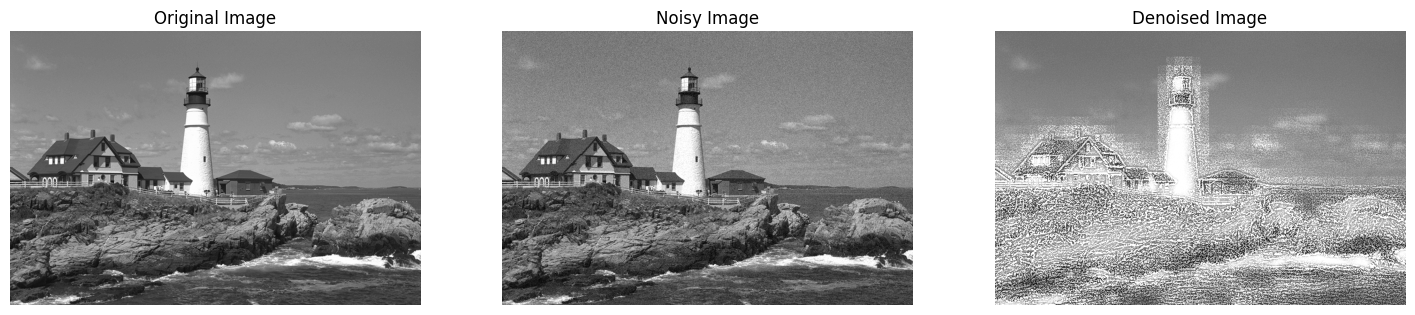

In [ ]:
# Step 1: Combine the denoised high-pass image with the low-pass original to reconstruct the denoised image
denoised_img = denoised_high_pass_img + low_pass_original

# Convert the pixel values to the appropriate range and data type for display
denoised_img_clipped = np.clip(denoised_img, 0, 255).astype(np.uint8)

# Plot the original image, the noisy image, and the denoised image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(gray_img_255, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(noisy_img_clipped, cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(denoised_img_clipped, cmap='gray')
axes[2].set_title('Denoised Image')
axes[2].axis('off')

plt.show()

**Calculate MSE**

In [ ]:
import numpy as np

# Calculate MSE function
def calculate_mse(imageA, imageB):
    err = np.mean((imageA.astype("float") - imageB.astype("float")) ** 2)
    return err

mse_value = calculate_mse(gray_img_255, denoised_img_clipped)
mse_value

7359.116267726208

**Observation:**


*   Images with a high dynamic range or a lot of detail might naturally have a higher MSE after denoising because even small changes in detail due to denoising can result in larger squared errors.
*   The level of noise initially present in the image can affect the MSE after denoising. If the noise level was high, a higher MSE might still reflect a significant improvement in image quality.





# **Part III**

**Applying a discrete wavelet transform (DWT) to decompose the noisy grayscale image into its high-pass and low-pass components.**

Shape of Approximation coefficients: (256, 384)
Shape of Horizontal detail coefficients: (256, 384)
Shape of Vertical detail coefficients: (256, 384)
Shape of Diagonal detail coefficients: (256, 384)


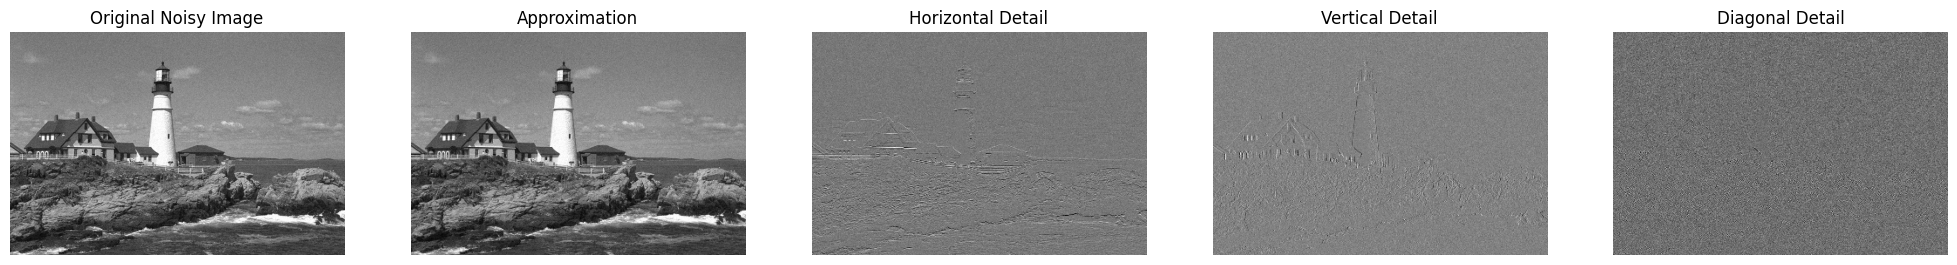

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Function to plot images in a subplot
def plot_images(images, titles, cmap='gray'):
    """Utility function for plotting images side by side."""
    n = len(images)
    plt.figure(figsize=(n * 5, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# 1. Apply Discrete Wavelet Transform
# Using 'haar' wavelet
coeffs = pywt.dwt2(noisy_img_clipped, 'haar')
cA, (cH, cV, cD) = coeffs  # cA: Approximation, cH: Horizontal, cV: Vertical, cD: Diagonal details

# 2. Debugging print statements
print("Shape of Approximation coefficients:", cA.shape)
print("Shape of Horizontal detail coefficients:", cH.shape)
print("Shape of Vertical detail coefficients:", cV.shape)
print("Shape of Diagonal detail coefficients:", cD.shape)

# 3. Plot and Observe
# Original noisy image and its DWT components
images = [noisy_img_clipped, cA, cH, cV, cD]
titles = ['Original Noisy Image', 'Approximation', 'Horizontal Detail', 'Vertical Detail', 'Diagonal Detail']
plot_images(images, titles)

In [ ]:
def sure_shrinkage(patch, sigma):
    n = patch.size
    # Define the range of thresholds within the function scope
    thresholds = np.linspace(np.min(np.abs(patch)), np.max(np.abs(patch)), num=100)
    risks = np.zeros(thresholds.shape)  # Correctly create an array to hold risks for each threshold

    # Compute the SURE for a range of thresholds
    for i, t in enumerate(thresholds):
        thresholded = patch * (np.abs(patch) > t)
        # Applying the SURE formula
        risk_t = n * sigma**2 + np.sum((patch ** 2 - sigma**2) * (np.abs(patch) <= t)) \
                 - 2 * sigma**2 * np.sum(np.abs(patch) > t)
        risks[i] = risk_t  # Store the computed risk for the current threshold

    # Find the threshold that minimizes the risk
    optimal_threshold = thresholds[np.argmin(risks)]

    # Apply soft thresholding with the optimal threshold
    optimal_shrinkage = np.sign(patch) * np.maximum(np.abs(patch) - optimal_threshold, 0)

    return optimal_shrinkage

**Patch extraction and threshold calculation steps**

In [ ]:
def estimate_sigma(coefficients):
    # Median Absolute Deviation (MAD) is a robust estimator of standard deviation
    return np.median(np.abs(coefficients - np.median(coefficients))) / 0.6745

In [ ]:
# Patch Extraction
def extract_patches(coefs, patch_size=32):
    patches = []
    for i in range(0, coefs.shape[0], patch_size):
        for j in range(0, coefs.shape[1], patch_size):
            patch = coefs[i:i + patch_size, j:j + patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
    return patches

# Apply SureShrink to each patch and reconstruct the denoised image
def denoise_with_sure_shrinkage(coefs, sigma, patch_size=32):
    # Extract patches
    patches = extract_patches(coefs, patch_size)

    # Apply SureShrink to each patch
    denoised_patches = [sure_shrinkage(patch, sigma) for patch in patches]

    # Combine patches back into the image
    denoised_image = np.zeros_like(coefs)
    patch_index = 0
    for i in range(0, coefs.shape[0], patch_size):
        for j in range(0, coefs.shape[1], patch_size):
            if i + patch_size <= coefs.shape[0] and j + patch_size <= coefs.shape[1]:
                denoised_image[i:i + patch_size, j:j + patch_size] = denoised_patches[patch_index]
                patch_index += 1
    return denoised_image

# Estimate noise level sigma from one of the high-frequency components
sigma = estimate_sigma(cH)  # Function from previous steps

# Denoise each detail coefficients with SureShrink
denoised_cH = denoise_with_sure_shrinkage(cH, sigma)
denoised_cV = denoise_with_sure_shrinkage(cV, sigma)
denoised_cD = denoise_with_sure_shrinkage(cD, sigma)

**Inverse Discrete Wavelet Transform**

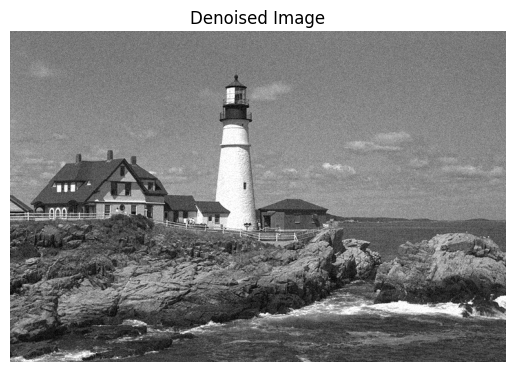

In [ ]:
import pywt

# Combine the denoised detail coefficients with the approximation coefficients
def reconstruct_image(cA, denoised_cH, denoised_cV, denoised_cD, wavelet='haar'):
    # Reconstruct the image using the inverse DWT
    denoised_image = pywt.idwt2((cA, (denoised_cH, denoised_cV, denoised_cD)), wavelet)
    return denoised_image

# cA is approximation coefficient array
denoised_image = reconstruct_image(cA, denoised_cH, denoised_cV, denoised_cD)

# Visual Evaluation
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

**Calculate MSE**

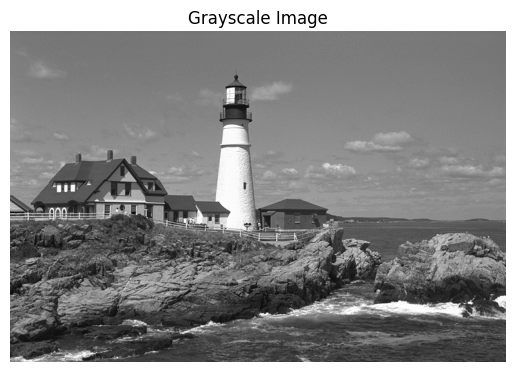

In [ ]:
import matplotlib.image as mpimg

# Load the original RGB image
rgb_image_path = '/content/drive/MyDrive/AIP Assignment 3/lighthouse2.bmp'
rgb_image = mpimg.imread(rgb_image_path)

# Convert the RGB image to Grayscale
grayscale_image = np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

# Show the grayscale image
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')
plt.show()

In [ ]:
def calculate_mse(original, denoised):
    # Ensure the images are the same shape
    if original.shape != denoised.shape:
        raise ValueError("The images must have the same dimensions.")

    # Calculate MSE
    mse = np.mean((original - denoised) ** 2)
    return mse


# Calculate the MSE
mse_value = calculate_mse(grayscale_image, denoised_image)
print(f"MSE: {mse_value}")

MSE: 100.55855822124109
